https://github.com/OpenXAIProject/GNNExplainer-Tutorial/blob/master/gnnexplainer_cora.ipynb

Dataset

In [ ]:
%matplotlib inline

from torch_geometric.data import Data, DataLoader
from torch_geometric.datasets import TUDataset, Planetoid
from torch_geometric.nn import GCNConv, Set2Set, GNNExplainer
import torch_geometric.transforms as T
import torch
import torch.nn.functional as F
import os
from tqdm import tqdm, trange

import matplotlib.pyplot as plt

In [ ]:
#Load the dataset
dataset = 'cora'
path = os.path.join(os.getcwd(), 'data', 'Planetoid')
train_dataset = Planetoid(path, dataset, transform=T.NormalizeFeatures())

# Since the dataset is comprised of a single huge graph, we extract that graph by indexing 0.
data = train_dataset[0]

# Since there is only 1 graph, the train/test split is done by masking regions of the graph. We split the last 500+500 nodes as val and test, and use the rest as the training data.
data.train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.train_mask[:data.num_nodes - 1000] = 1
data.val_mask = None
data.test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.test_mask[data.num_nodes - 500:] = 1

Processing...
Done!


Build model

In [ ]:
class Net(torch.nn.Module):
    def __init__(self, num_features, dim=16, num_classes=1):
        super(Net, self).__init__()
        self.conv1 = GCNConv(num_features, dim)
        self.conv2 = GCNConv(dim, num_classes)

    def forward(self, x, edge_index, data=None):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

Training

In [ ]:
epochs = 200
dim = 16
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net(num_features=train_dataset.num_features, dim=dim, num_classes=train_dataset.num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-3)

In [ ]:
def test(model, data):
    model.eval()
    logits, accs = model(data.x, data.edge_index, data), []
    for _, mask in data('train_mask', 'test_mask'):
        pred = logits[mask].max(1)[1]
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
        accs.append(acc)
    return accs

In [ ]:
loss = 999.0
train_acc = 0.0
test_acc = 0.0

t = trange(epochs, desc="Stats: ", position=0)

for epoch in t:

    model.train()
    
    loss = 0

    data = data.to(device)
    optimizer.zero_grad()
    log_logits = model(data.x, data.edge_index, data)

    # Since the data is a single huge graph, training on the training set is done by masking the nodes that are not in the training set.
    loss = F.nll_loss(log_logits[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

    # validate
    train_acc, test_acc = test(model, data)
    train_loss = loss
    
    t.set_description('[Train_loss:{:.6f} Train_acc: {:.4f}, Test_acc: {:.4f}]'.format(loss, train_acc, test_acc))

[Train_loss:1.553071 Train_acc: 0.4268, Test_acc: 0.4420]: 100%|██████████| 200/200 [00:06<00:00, 29.46it/s]


GNNExplainer

In [ ]:
node_idx = 10
x, edge_index = data.x, data.edge_index
explainer = GNNExplainer(model, epochs=200)
node_feat_mask, edge_mask = explainer.explain_node(node_idx, x, edge_index)

Explain node 10: 100%|██████████| 200/200 [00:00<00:00, 373.67it/s]


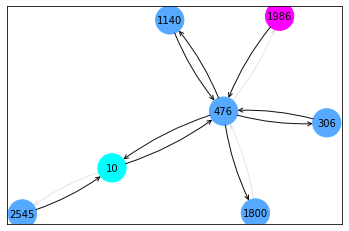

In [ ]:
ax, G = explainer.visualize_subgraph(node_idx, edge_index, edge_mask, y=data.y)
plt.show()